In [36]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
base = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/petra/petr4_treinamento.csv')
base = base.dropna()

base_treino = base.iloc[:,1:7].values

norm = MinMaxScaler(feature_range=(0,1))

base_treino_norm = norm.fit_transform(base_treino)

norm_previsao = MinMaxScaler(feature_range=(0,1))
norm_previsao.fit_transform(base_treino[:,0:1])

array([[0.76501938],
       [0.7562984 ],
       [0.78149225],
       ...,
       [0.57122093],
       [0.57655039],
       [0.57655039]])

In [39]:
base_treino_norm

array([[0.76501938, 0.77266112, 0.79682707, 0.76080559, 0.6838135 ,
        0.04318274],
       [0.7562984 , 0.78187106, 0.79733884, 0.79567784, 0.71590949,
        0.0437121 ],
       [0.78149225, 0.79253519, 0.82139202, 0.79715132, 0.71726583,
        0.05170752],
       ...,
       [0.57122093, 0.57537562, 0.60696008, 0.58202356, 0.58202349,
        0.03369652],
       [0.57655039, 0.57489089, 0.60798362, 0.5844794 , 0.58447937,
        0.02720006],
       [0.57655039, 0.57343674, 0.61310133, 0.5844794 , 0.58447937,
        0.        ]])

In [40]:
previsores = []
preco_real = []

for i in range(90, 1242):
  previsores.append(base_treino_norm[i-90:i,0:6])
  preco_real.append(base_treino_norm[i,0])

previsores, preco_real = np.array(previsores), np.array(preco_real)

#LSTM
lstm = Sequential()
lstm.add(LSTM(units = 100, return_sequences=True, input_shape = (previsores.shape[1],6)))
lstm.add(Dropout(0.3))
lstm.add(LSTM(units = 50, return_sequences=True))
lstm.add(Dropout(0.3))
lstm.add(LSTM(units = 50, return_sequences=True))
lstm.add(Dropout(0.3))
lstm.add(LSTM(units = 50))
lstm.add(Dropout(0.3))
lstm.add(Dense(units=1, activation='sigmoid'))

lstm.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['mean_absolute_error'])

In [41]:
es = EarlyStopping(monitor='loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, verbose=1)
mcp = ModelCheckpoint(filepath='pesos.h5', monitor='loss', save_best_only=True, verbose=1)
lstm.fit(previsores, preco_real, epochs=500, batch_size=32)

Epoch 1/500
36/36 [==============================] - 6s 19ms/step - loss: 0.0184 - mean_absolute_error: 0.1060
Epoch 2/500
36/36 [==============================] - 1s 16ms/step - loss: 0.0081 - mean_absolute_error: 0.0727
Epoch 3/500
36/36 [==============================] - 1s 16ms/step - loss: 0.0062 - mean_absolute_error: 0.0619
Epoch 4/500
36/36 [==============================] - 1s 16ms/step - loss: 0.0053 - mean_absolute_error: 0.0571
Epoch 5/500
36/36 [==============================] - 1s 17ms/step - loss: 0.0051 - mean_absolute_error: 0.0563
Epoch 6/500
36/36 [==============================] - 1s 17ms/step - loss: 0.0047 - mean_absolute_error: 0.0535
Epoch 7/500
36/36 [==============================] - 1s 15ms/step - loss: 0.0042 - mean_absolute_error: 0.0500
Epoch 8/500
36/36 [==============================] - 1s 15ms/step - loss: 0.0042 - mean_absolute_error: 0.0505
Epoch 9/500
36/36 [==============================] - 1s 15ms/step - loss: 0.0041 - mean_absolute_error: 0.0489
E

In [42]:
base_teste = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/petra/petr4_teste.csv')
preco_real = base_teste.iloc[:,1:2].values
frames = [base, base_teste]

base_completa = pd.concat(frames)
base_completa = base_completa.drop('Date', axis=1)

entradas = base_completa[len(base_completa)-len(base_teste)-90:].values
entradas = norm.transform(entradas)




In [43]:
X_teste = []
for i in range(90, 112):
  X_teste.append(entradas[i-90:i,0:6])

X_teste = np.array(X_teste)
previsoes = lstm.predict(X_teste)
previsoes = norm_previsao.inverse_transform(previsoes)

1/1 [==============================] - 1s 1s/step


In [44]:
previsoes.mean()

17.857008

In [45]:
preco_real.mean()

17.87454563636364

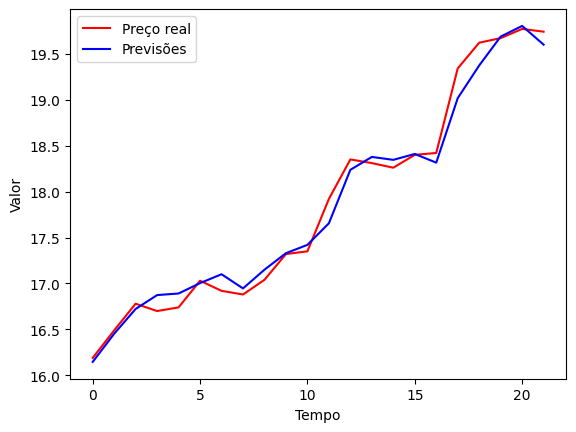

In [46]:
plt.plot(preco_real, color='red', label='Preço real')
plt.plot(previsoes, color='blue', label='Previsões')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()
plt.show()